In [ ]:
#@title Copyright 2023 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Change Detection on Google Earth Engine 
# Part 2 The iMAD Algorithm

 Authors: mortcanty, allannielsen


## Context

In Part 1 of this Tutorial a statistical approach to detecting changes in pairs of multispectral remote sensing images called Multivariate Alteration Detection (MAD) was explained. The MAD change images were obtained by first maximizing the correlations between the original image bands and then subtracting one from the other. The resulting difference bands, so-called MAD variates, contained the change information. They were shown to to be ordered by increasing variance and to be mutually uncorrelated. However they were also seen to be not easily interpretable. Now, in Part 2, we introduce an iteration scheme which performs the MAD transformation exclusively on those pixels which mark areas in the images which have physically not changed, thereby establishing a well-defined backgound of invariant pixels against which to discriminate changes.



## Preliminaries

In [1]:
# enter your own export to assets path name here -----------
EXPORT_PATH = 'projects/ee-mortcanty/assets/imad/'
# ------------------------------------------------

In [4]:
# Authenticate
COLAB_AUTH_FLOW_CLOUD_PROJECT_FOR_API_CALLS = None

import ee
import google
import os

if COLAB_AUTH_FLOW_CLOUD_PROJECT_FOR_API_CALLS is None:
  print("Authenticating using Notebook auth...")
  if os.path.exists(ee.oauth.get_credentials_path()) is False:
    ee.Authenticate()
  else:
    print('\N{check mark} '
          'Previously created authentication credentials were found.')
  ee.Initialize()
else:
  print('Authenticating using Colab auth...')
  # Authenticate to populate Application Default Credentials in the Colab VM.
  google.colab.auth.authenticate_user()
  # Create credentials needed for accessing Earth Engine.
  credentials, auth_project_id = google.auth.default()
  # Initialize Earth Engine.
  ee.Initialize(credentials, project=COLAB_AUTH_FLOW_CLOUD_PROJECT_FOR_API_CALLS)
print('\N{check mark} Successfully initialized!')

Authenticating using Notebook auth...
✓ Previously created authentication credentials were found.
✓ Successfully initialized!


In [5]:
# Install the ee_jupyter package
import os
try:
  import ee_jupyter
except ModuleNotFoundError:
  print('ee_jupyter was not found. Installing now...')
  result = os.system('pip -q install earthengine-jupyter')
  import ee_jupyter
print(f'ee_jupyter (version {ee_jupyter.__version__}) '
        f'is installed.')

ee_jupyter (version 0.0.7) is installed.


In [6]:
# Import other packages used in the tutorial
%matplotlib inline
import numpy as np
import random, time
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

from ee_jupyter.colab import set_colab_output_cell_height
from ee_jupyter.ipyleaflet import Map
from ee_jupyter.ipyleaflet import Inspector
from pprint import pprint  # for pretty printing

In [7]:
#@title Routines from Part 1

def trunc(values, dec = 3):
    ''' Truncate a 1-D array to dec decimal places'''    
    return np.trunc(values*10**dec)/(10**dec)
    
# Display an image in a one percent linear stretch
def display_ls(image, map, name, centered = False):
    bns = image.bandNames().length().getInfo()
    if bns == 3:
        image = image.rename('B1', 'B2', 'B3')
        pb_99 = ['B1_p99', 'B2_p99', 'B3_p99']
        pb_1 = ['B1_p1', 'B2_p1', 'B3_p1']
        img = ee.Image.rgb(image.select('B1'), image.select('B2'), image.select('B3'))
    else:
        image = image.rename('B1')
        pb_99 = ['B1_p99']
        pb_1 = ['B1_p1']
        img = image.select('B1')
    percentiles = image.reduceRegion(ee.Reducer.percentile([1, 99]), maxPixels=1e11)
    mx = percentiles.values(pb_99)
    if centered:
        mn = ee.Array(mx).multiply(-1).toList()
    else:
        mn = percentiles.values(pb_1)
    map.addLayer(img, {'min': mn, 'max': mx}, name)
    
def collect(aoi, t1a ,t1b, t2a, t2b):
    try:
        im1 = ee.Image( ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t1a), ee.Date(t1b))
                               .filter(ee.Filter.contains(rightValue=aoi,leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               .first()
                               .clip(aoi) )
        im2 = ee.Image( ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t2a), ee.Date(t2b))
                               .filter(ee.Filter.contains(rightValue=aoi,leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               .first()
                               .clip(aoi) )
        timestamp = im1.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        timestamp = im2.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        return (im1, im2)
    except Exception as e:
        print('Error: %s'%e)

def covarw(image, weights=None, scale=20, maxPixels=1e10):
    '''Return the centered image and its weighted covariance matrix'''  
    try:
        geometry = image.geometry()
        bandNames = image.bandNames()
        N = bandNames.length()
        if weights is None:
            weights = image.constant(1)
        weightsImage = image.multiply(ee.Image.constant(0)).add(weights)
        means = image.addBands(weightsImage) \
                    .reduceRegion(ee.Reducer.mean().repeat(N).splitWeights(), 
                                scale = scale, 
                                maxPixels = maxPixels) \
                    .toArray() \
                    .project([1])
        centered = image.toArray().subtract(means) 
        B1 = centered.bandNames().get(0)       
        b1 = weights.bandNames().get(0)     
        nPixels = ee.Number(centered.reduceRegion(ee.Reducer.count(), 
                                                scale=scale, 
                                                maxPixels=maxPixels).get(B1)) 
        sumWeights = ee.Number(weights.reduceRegion(ee.Reducer.sum(), 
                                                    geometry=geometry, 
                                                    scale=scale, 
                                                    maxPixels=maxPixels).get(b1))
        covw = centered.multiply(weights.sqrt()) \
                    .toArray() \
                    .reduceRegion(ee.Reducer.centeredCovariance(), 
                                    geometry=geometry, 
                                    scale=scale,
                                    maxPixels=maxPixels) \
                    .get('array')
        covw = ee.Array(covw).multiply(nPixels).divide(sumWeights)
        return (centered.arrayFlatten([bandNames]), covw)
    except Exception as e:
        print('Error: %s'%e)

def corr(cov):
    ''' transfrom covariance matrix to correlation matrix '''
    # diagonal matrix of inverse sigmas
    sInv = cov.matrixDiagonal().sqrt().matrixToDiag().matrixInverse()
    # transform
    corr = sInv.matrixMultiply(cov).matrixMultiply(sInv).getInfo()
    # truncate
    return [list(map(trunc, corr[i])) for i in range(len(corr))]   

def geneiv(C,B):
    '''Return the eignvalues and eigenvectors of the generalized eigenproblem
                         C*X = lambda*B*X '''
    try:                         
        C = ee.Array(C)
        B = ee.Array(B)  
        #  Li = choldc(B)^-1
        Li = ee.Array(B.matrixCholeskyDecomposition().get('L')).matrixInverse()
        #  solve symmetric, ordinary eigenproblem Li*C*Li^T*x = lambda*x
        Xa = Li.matrixMultiply(C) \
            .matrixMultiply(Li.matrixTranspose()) \
            .eigen()
        #  eigenvalues as a row vector
        lambdas = Xa.slice(1, 0, 1).matrixTranspose()
        #  eigenvectors as columns
        X = Xa.slice(1, 1).matrixTranspose()  
        #  generalized eigenvectors as columns, Li^T*X
        eigenvecs = Li.matrixTranspose().matrixMultiply(X)
        return (lambdas, eigenvecs) 
    except Exception as e:
        print('Error: %s'%e)        

def mad_run(image1, image2, scale=20): 
    ''' The MAD transformation of two multiband images '''
    try:
        image = image1.addBands(image2) 
        nBands = image.bandNames().length().divide(2) 
        centeredImage,covarArray = covarw(image,scale=scale)
        bNames = centeredImage.bandNames()
        bNames1 = bNames.slice(0,nBands)
        bNames2 = bNames.slice(nBands)
        centeredImage1 = centeredImage.select(bNames1)
        centeredImage2 = centeredImage.select(bNames2) 
        s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
        s22 = covarArray.slice(0, nBands).slice(1, nBands)
        s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
        s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)      
        c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
        b1 = s11
        c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
        b2 = s22
        #  solution of generalized eigenproblems     
        lambdas, A = geneiv(c1, b1)
        _,       B = geneiv(c2, b2) 
        rhos = lambdas.sqrt().project(ee.List([1]))
        #  MAD variances    
        sigma2s = rhos.subtract(1).multiply(-2).toList() 
        sigma2s = ee.Image.constant(sigma2s)
        #  ensure sum of positive correlations between X and U is positive
        tmp = s11.matrixDiagonal().sqrt()
        ones = tmp.multiply(0).add(1)
        tmp = ones.divide(tmp).matrixToDiag()
        s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(),[0]).transpose()
        A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
        #  ensure positive correlation
        tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
        tmp = tmp.divide(tmp.abs()).matrixToDiag()
        B = B.matrixMultiply(tmp)           
        #  canonical and MAD variates as images
        centeredImage1Array = centeredImage1.toArray().toArray(1)
        centeredImage2Array = centeredImage2.toArray().toArray(1)
        U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                    .arrayProject([0]) \
                    .arrayFlatten([bNames2]) 
        V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                    .arrayProject([0]) \
                    .arrayFlatten([bNames2]) 
        MAD = U.subtract(V)  
        #  chi square image
        Z = MAD.pow(2) \
               .divide(sigma2s) \
               .reduce(ee.Reducer.sum())                             
        return (U, V, MAD, Z)    
    except Exception as e:
        print('Error: %s'%e)                                                   

## Iterative re-weighting
 
Let's imagine two images of the same scene acquired at different times
under similar conditions, like our two Sentinel-2 images from Part 1, but for which no ground reflectance
changes have occurred whatsoever. Then the only differences
between them will be due to random effects like instrument noise
and atmospheric fluctuation. In such a case we would expect that
the histogram of any difference component that we generate will
be very nearly Gaussian. In particular, the MAD variates, being as we have seen
uncorrelated, should  follow a multivariate, zero mean normal
distribution with diagonal covariance matrix. 

$$
\Sigma_M = \pmatrix{\sigma^2_{M_1} &0 &\cdots &0 \cr
                            0 & \sigma^2_{M_2} &\cdots &0 \cr
                            \vdots &\vdots &\cdots &0 \cr
                            0 & 0 &\cdots &\sigma^2_{M_N}}.
$$


Change observations
would deviate more or less strongly from such a distribution.
We might therefore expect an improvement in the sensitivity of the MAD
transformation _if we can establish a better background
of no change against which to detect change._ This can be done in an iteration scheme [(Nielsen 2007)](https://www2.imm.dtu.dk/pubdb/pubs/4695-full.html) in which, when calculating the statistics  for each successive iteration of the MAD transformation, observations are weighted in some appropriate fashion.
 
Recall that the variable $Z$ represents the sum of the squares of the standardized MAD variates,
 
$$
Z = \sum_{i=1}^N\left({M_i\over \sigma_{M_i}}\right)^2,
$$
 
where $\sigma^2_{M_i}$ is given by Equation (8) in the first Tutorial,

$$
\sigma_{M_i}^2={\rm var}(U_i-V_i) = 2(1-\rho_i),\quad i=1\dots N,
$$

and $\rho_i = {\rm cov}(U_i,V_i)$. Then, since the no-change observations are expected to be
normally distributed and uncorrelated, basic statistical theory tells us 
that the values of $Z$ corresponding to no-change observations should be _chi-square 
distributed_ with $N$ degrees of freedom. 
Let's check to what extent this is true for the MAD variates that we have determined so far for the Landkreis Olpe scene.

Sun Jun 13 10:36:49 2021
Thu Jun 16 10:46:56 2022


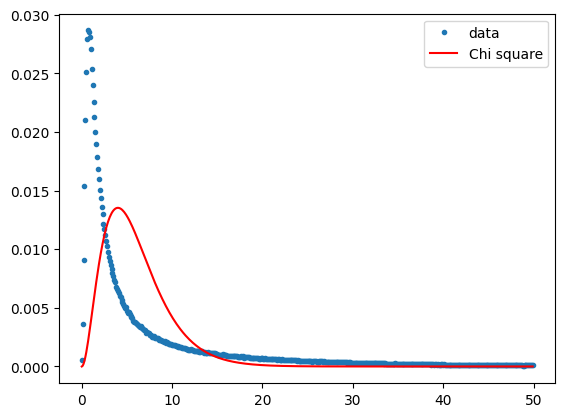

In [8]:
# Landkreis Olpe
aois = ee.FeatureCollection('projects/ee-mortcanty/assets/dvg1krs_nw').geometry()
aoi = ee.Geometry(aois.geometries().get(26))

visirbands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
visbands = ['B2', 'B3', 'B4']
rededgebands = ['B5', 'B6', 'B7', 'B8A']

# Collect the two Sentinel-2 images
im1, im2 = collect(aoi, '2021-06-01', '2021-06-30', '2022-06-01', '2022-06-30')

# Re-run MAD
U, V, MAD, Z = mad_run(im1.select(visirbands), im2.select(visirbands), scale=20)

# Plot histogram of Z
hist = Z.reduceRegion(ee.Reducer.fixedHistogram(0, 50, 500), aoi, scale=20).get('sum').getInfo()
a = np.array(hist)
x = a[:, 0]                # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.plot(x, y, '.', label='data')
# The chi square distribution with 6 degrees of freedom
plt.plot(x, chi2.pdf(x, 6)/10, '-r', label = 'Chi square')
plt.legend()
plt.show()

Clearly not the case at all. Which is to be expected, since there are many change pixels in the scene and we have made no attempt to discriminate them. 

In fact it is easy to show that $Z$ is a _likelihood ratio test statistic_ for change, see  the discussion of statistical hypothesis testing in the [SAR Tutorial](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2) and the discussion on pp.390-391 in [Canty (2019)](https://www.taylorfrancis.com/books/image-analysis-classification-change-detection-remote-sensing-morton-john-canty/10.1201/9780429464348). Under the hypothesis that no change has occurred, the test statistic $Z$ will follow, as we said, a chi square distribution. The so-called $p$-*value* is a measure of the extent to which this is true. For an observation $z$ of the test statistic, the $p$-value is the probability that any sample drawn from the chi-square distribution could be as large as $z$ or larger. This is given by
 
$$
p(z) = 1-P_{\chi^2;N}(z),\quad 0 < p(z) < 1,
$$
 
where $P_{\chi^2;N}(z)$ is the cumulative chi-square probability distribution, i.e., the area under the chi-square distribution up to the value $z$, and $p(z)$ is its complement.
All $p$-values are equally likely if no change has occurred at that pixel location,$^\star$ but __change will always be associated with small $p$-values__.  Therefore in order to eliminate the change observations from the MAD transformation, the $p$-value itself can be used to weight each pixel before re-sampling the images to determine the statistics for the next iteration. (This was the motivation for coding a _weighted_ covariance matrix routine in Part 1 earlier). The influence of the change observations on the MAD transformation is thereby gradually reduced. Iteration  continues until some stopping criterion is met, such as lack of significant change in the canonical correlations $\rho_i$. 
The whole procedure constitutes the *iMAD algorithm*. It is implemented in the GEE Python API in the following cell:

$\star$ Thus the $p$-value is *not* a no-change probability, a common misapprehension! See again the [SAR Tutorial](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2).



In [9]:
#@title The iMAD code
def chi2cdf(Z,df):
    '''Chi square cumulative distribution function with df degrees of freedom'''
    return ee.Image(Z.divide(2)).gammainc(ee.Number(df).divide(2))

def imad(current,prev):
    '''Iterator function for iMAD'''
    done =  ee.Number(ee.Dictionary(prev).get('done'))
    return ee.Algorithms.If(done, prev, imad1(current, prev))

def imad1(current,prev): 
    ''' Iteratively re-weighted MAD '''
    image = ee.Image(ee.Dictionary(prev).get('image'))
    Z = ee.Image(ee.Dictionary(prev).get('Z'))      
    allrhos = ee.List(ee.Dictionary(prev).get('allrhos'))  
    nBands = image.bandNames().length().divide(2) 
    weights = chi2cdf(Z,nBands).subtract(1).multiply(-1)
    scale = ee.Number(ee.Dictionary(prev).get('scale'))
    niter = ee.Number(ee.Dictionary(prev).get('niter'))
    # weighted stacked image and weighted covariance matrix
    centeredImage,covarArray = covarw(image, weights, scale)
    bNames = centeredImage.bandNames()
    bNames1 = bNames.slice(0, nBands)
    bNames2 = bNames.slice(nBands)
    centeredImage1 = centeredImage.select(bNames1)
    centeredImage2 = centeredImage.select(bNames2) 
    s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
    s22 = covarArray.slice(0, nBands).slice(1, nBands)
    s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
    s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)      
    c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
    b1 = s11
    c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
    b2 = s22
    # solution of generalized eigenproblems     
    lambdas, A = geneiv(c1, b1)
    _, B       = geneiv(c2, b2) 
    rhos = lambdas.sqrt().project(ee.List([1]))
    # test for convergence    
    lastrhos = ee.Array(allrhos.get(-1))
    done = rhos.subtract(lastrhos) \
               .abs() \
               .reduce(ee.Reducer.max(),ee.List([0])) \
               .lt(ee.Number(0.0001)) \
               .toList() \
               .get(0)       
    allrhos = allrhos.cat([rhos.toList()]) 
    # MAD variances    
    sigma2s = rhos.subtract(1).multiply(-2).toList() 
    sigma2s = ee.Image.constant(sigma2s)
    # ensure sum of positive correlations between X and U is positive
    tmp = s11.matrixDiagonal().sqrt()
    ones = tmp.multiply(0).add(1)
    tmp = ones.divide(tmp).matrixToDiag()
    s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(),[0]).transpose()
    A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
    # ensure positive correlation
    tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
    tmp = tmp.divide(tmp.abs()).matrixToDiag()
    B = B.matrixMultiply(tmp)           
    # canonical and MAD variates 
    centeredImage1Array = centeredImage1.toArray().toArray(1)
    centeredImage2Array = centeredImage2.toArray().toArray(1)
    U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames1])
    V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames2])   
    iMAD = U.subtract(V)
    # chi square image
    Z = iMAD.pow(2) \
              .divide(sigma2s) \
              .reduce(ee.Reducer.sum())   
    return ee.Dictionary({'done': done, 'scale': scale, 'niter': niter.add(1),
                          'image': image, 'allrhos': allrhos, 'Z': Z, 'iMAD': iMAD})

Here is a routine to run the iMAD algorithm as an export task, avoiding memory and time limitations in the active runtime:

In [10]:
#@title Run iMAD algorithm as export task
def run_imad(aoi, image1, image2, assetFN, scale=20, maxiter=100):
    try: 
        N = image1.bandNames().length().getInfo()
        imadnames = ['iMAD'+str(i+1) for i in range(N)]
        imadnames.append('Z')
        # maximum iterations
        inputlist = ee.List.sequence(1, maxiter)
        first = ee.Dictionary({'done':0,
                            'scale': scale,
                            'niter': ee.Number(0),
                            'image': image1.addBands(image2),
                            'allrhos': [ee.List.sequence(1, N)],
                            'Z': ee.Image.constant(0),
                            'iMAD': ee.Image.constant(0)}) 
        # iteration
        result = ee.Dictionary(inputlist.iterate(imad, first)) 
        # retrieve results      
        iMAD = ee.Image(result.get('iMAD')).clip(aoi) 
        rhos = ee.String.encodeJSON(ee.List(result.get('allrhos')).get(-1))
        Z = ee.Image(result.get('Z'))
        niter = ee.Number(result.get('niter'))
        # export iMAD and Z as a singe image, including rhos and number of iterations in properties
        iMAD_export = ee.Image.cat(iMAD, Z).rename(imadnames).set('rhos', rhos, 'niter', niter)
        assetId = EXPORT_PATH + assetFN
        assexport = ee.batch.Export.image.toAsset(iMAD_export,
                        description = 'assetExportTask',
                        assetId = assetId, scale = scale, maxPixels=1e10)
        assexport.start()
        print('Exporting iMAD to %s\n task id: %s'%(assetId, str(assexport.id)))  
    except Exception as e:
        print('Error: %s'%e)        

and here we run it on our two images:

In [ ]:
run_imad(aoi, im1.select(visirbands), im2.select(visirbands), 'LankreisOlpe')

After the export finishes, the number of iterations and the final canonical correlations can be read from properties of the exported image:

In [11]:
im_imad = ee.Image(EXPORT_PATH + 'LandkreisOlpe').select(0, 1, 2, 3, 4, 5)
im_z = ee.Image(EXPORT_PATH + 'LandkreisOlpe').select(6).rename('Z')
niter = im_imad.get('niter').getInfo()
rhos = ee.List(im_imad.get('rhos')).getInfo()
print('iteratons: %i'%niter)
print('canonical correlations: %s'%rhos)

iteratons: 28
canonical correlations: [0.9981250148930757,0.981830899543524,0.9594475307386057,0.8816514687632091,0.8470795072420434,0.6869925605157227]


We got convergence after 28 iterations, and the correlations are very close to one for the first canonical variates. It might now be interesting to check if the test statistic $Z$ has the expected chi square distribution when evaluated for the no change pixels. To to eliminate the changes at the 5% significance level  we set a lower threshold of $\alpha = 0.05$ on the $p$-values (recall: small p-values signify change).

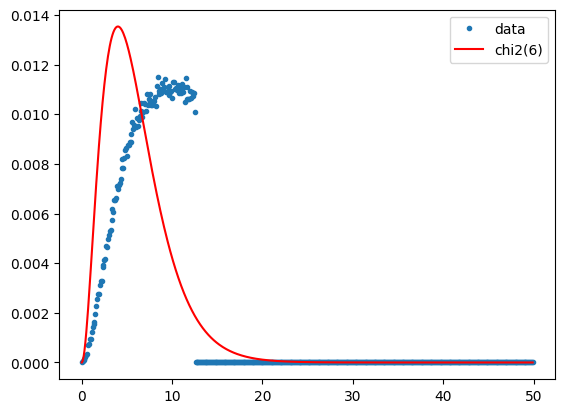

In [12]:
scale = 20
# p-values image
pval = chi2cdf(im_z, 6).subtract(1).multiply(-1).rename('pval')
# no-change mask (use p-values greater than 0.05)
noChangeMask = pval.gt(0.05)
hist = im_z.updateMask(noChangeMask).reduceRegion(ee.Reducer \
           .fixedHistogram(0, 50, 500), aoi, scale = scale, maxPixels = 1e11) \
           .get('Z').getInfo()
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.plot(x, y, '.', label = 'data')
plt.plot(x, chi2.pdf(x, 6)/10, '-r',label = 'chi2(6)')
plt.legend()
plt.show()

Agreement is not perfect but the plot is certainly closer to the ideal chi square distribution after iteration than after the single MAD transformation. So let's display the _iMAD_ image:

In [13]:
location = aoi.centroid().coordinates().getInfo()[::-1]
M1 = Map(**{'center': location, 'zoom': 11})
display_ls(im1.select(visbands), M1, 'im1')
display_ls(im2.select(visbands), M1, 'im2')
display_ls(im_imad.select('iMAD1', 'iMAD2', 'iMAD3'), M1, 'iMAD123', True)

M1

Map(center=[51.08617675675536, 7.976478425048881], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Gray pixels point to no change, while the wide range of color in the iMAD variates indicates a good discrimination of the types of change occuring. 

**Aside:** We are of course primarily interested in extracting the changes in the iMAD image, especially those which mark clear cutting, and we'll come back to them in a moment. However, now that what we think to be the no change pixels have been isolated, we could also perform a regression analysis on them to determine how well the radiometric parameters of the two Sentinel-2 acquisitions compare. If surface rather than top of atmosphere (TOA) reflectance images had been used for the example, we would expect a good match, i.e., a slope close to one and an intercept close to zero at all spectral wavelengths. In general for uncalibrated images  this will not be the case. In that event the regression coefficients can be applied to normalize one image (the target, say) to the other (the reference). This might be desirable for tracing features such as NDVI indices over a time series of acquisitions when the images have not been reduced to surface reflectances, see e.g. [Gan et al. (2021)](https://ieeexplore.ieee.org/document/9392311), or indeed for *harmonizing* the data from two different sensors of the same family such as Landsat 7 with Landsat 8. These topics will be the subject of Part 3.

But now let's look in more detail at the changes in the Landkreis Olpe scene.

### Clustering
In order to better interpret the change image, we can attempt an unsupervised classification. We'll see if we can get away with an ordinary K-means clusterer and a simple Euclidean distance measure for the complete iMAD image. We choose the number of clusters as 4 and leave all 12(!) other input parameters of the *wekaKmeans()* clusterer at their default values. We will also first standardize the iMAD image by dividing by the square root of the variances of the no change pixels, $\sigma_i = \sqrt{2(1-\rho_i)},\ i=1\dots 6$. This will favour a more compact no change cluster.

In [14]:
# standardize to no change sigmas
sigma2s = ee.Image.constant([2*(1-x) for x in eval(rhos)])
im_imadstd = im_imad.divide(sigma2s.sqrt())
# collect training data
training = im_imadstd.sample(region=aoi, scale=scale, numPixels=50000)
# train the clusterer
clusterer = ee.Clusterer.wekaKMeans(4).train(training)
# classify the standardized imad image
result = im_imadstd.cluster(clusterer)

Here we display the four clusters overlayed onto the two Sentinel 2 images:

In [15]:
M2 = Map(**{'center': location, 'zoom':13})
display_ls(im1.select(visbands),M2,'im1')
display_ls(im2.select(visbands),M2,'im2')
cluster0 = result.updateMask(result.eq(0))
cluster1 = result.updateMask(result.eq(1))
cluster2 = result.updateMask(result.eq(2))
cluster3 = result.updateMask(result.eq(3))
palette = ['red', 'yellow', 'blue', 'black']
M2.addLayer(cluster0, {'min': 0, 'max': 3, 'palette': palette}, 'new clearcuts')
M2.addLayer(cluster1, {'min': 0, 'max': 3, 'palette': palette}, 'agriculture')
M2.addLayer(cluster2, {'min': 0, 'max': 3, 'palette': palette}, 'prior clearcuts')
M2.addLayer(cluster3, {'min': 0, 'max': 3, 'palette': palette}, 'no change')

M2

Map(center=[51.08617675675536, 7.976478425048881], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Interpretation
**Cluster 0** (colored red in the preceding map) appears to classify the clear cuts occurring over the observation period quite well. 

**Cluster 1** (yellow) marks changes in the agricultural fields and pastures. 

**Cluster 2** (blue) is more ambiguous but can be mainly associated with changes in previously cleared forest (seasonal or new growth)  as well as with some changes in agricultural fields and in built up areas. 

**Cluster 3** (black) is no change:

### Comparison with Dynamic World
Google's recently released [Dynamic World](https://developers.google.com/earth-engine/tutorials/community/introduction-to-dynamic-world-pt-1) dataset contains near real-time land use land cover predictions created from Sentinel-2 imagery for nine land use land cover classes including forest (trees class). It is interesting to compare the loss in forest cover as determined from our iMAD/Cluster pipeline with the Dynamic World tree map for the comparable time period. In the code snippet below, we gather an image collection covering our observation period and simply mosaic them. The _mosaic()_ method composites the overlapping images according to their order in the collection (last on top), which is what we want because the changes in tree cover are occurring over the entire period. 

Generally the agreement is excellent, although the iMAD change map registers a number of small area clear cuts missed in the dynamic world map: 

In [16]:
dyn = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
                    .filterDate('2021-06-01', '2022-06-30') \
                    .filterBounds(aoi) \
                    .select('label').mosaic()
# 'trees' class = class 1
dw = dyn.clip(aoi).updateMask(dyn.eq(1))

M3 = Map(**{'center':location, 'zoom':13})
display_ls(im1.select(visbands), M3, 'im1')
display_ls(im2.select(visbands), M3, 'im2')
M3.addLayer(dw, {'min': 0, 'max': 1, 'palette': ['black', 'green']}, 'dynamic world')
M3.addLayer(cluster0, {'min': 0, 'max': 3, 'palette': palette}, 'new clearcuts')

M3

Map(center=[51.08617675675536, 7.976478425048881], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Simple Difference Revisited
In fact K-means clustering of the simple difference image also gives a fairly good discrimination of the clear cuts. This is because the NIR band is especially sensitive to all vegetation changes, and is also only weakly correlated with the other 5 bands. However close inspection indicates that there are many more false positives, especially in agricultural fields as well as in the reservoir.

In [17]:
M4 = Map(**{'center': location, 'zoom': 13})
diff = im1.subtract(im2).select(visirbands)
training = diff.sample(region=aoi, scale=20, numPixels=50000)
clusterer = ee.Clusterer.wekaKMeans(4).train(training)
result1 = diff.cluster(clusterer)
cluster0d = result1.updateMask(result1.eq(0))

display_ls(im1.select(visbands),M4,'im1')
display_ls(im2.select(visbands),M4,'im2')
M4.addLayer(cluster0d, {'min': 0, 'max': 3, 
                    'palette': ['orange', 'yellow', 'blue', 'black']}, 'clearcuts (diff)')
M4.addLayer(cluster0, {'min': 0, 'max': 3, 'palette': palette}, 'clearcuts (iMAD)')

M4

Map(center=[51.08617675675536, 7.976478425048881], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Deforestation Quantified
From the clear cuts class number 0 and using the _pixelArea()_ function we can extract the total area cleared between June, 2021 and June, 2022 within the Landkreis Olpe, whereby we exclude small areas covering less than 0.2 hectare:

In [18]:
# minimum contiguous area requirement (0.2 hectare)
contArea = cluster0.connectedPixelCount().selfMask()
# 0.2 hectare = 5 pixels @ 400 sq. meters
mp = contArea.gte(ee.Number(5)).selfMask()
# clear cuts in hectare
pixelArea = mp.multiply(ee.Image.pixelArea()).divide(10000)
clearcutArea = pixelArea.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=aoi,
                    scale=scale,
                    maxPixels=1e11)
ccA = clearcutArea.get('cluster').getInfo()
print(ccA, 'hectare')

3726.9415229785836 hectare


The most recent [commercial forest inventory](https://www.it.nrw/itnrw) recorded for the Landkreis Olpe as of December, 2019 was 40,178 hectare, so we have determined that, allowing for further decreases in 2020 and the first half of 2021, more than 9.3% of woodland was lost to drought/clearing within the time period measured.

Finally, repeating the calculation with the clear cuts determined with the simple difference image:

In [19]:
contArea = cluster0d.connectedPixelCount().selfMask()
mp = contArea.gte(ee.Number(5)).selfMask()
pixelArea = mp.multiply(ee.Image.pixelArea()).divide(10000)
clearcutArea = pixelArea.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=aoi,
                    scale=scale,
                    maxPixels=1e11)
ccA = clearcutArea.get('cluster').getInfo()
print(ccA, 'hectare')

4875.7986791732765 hectare


thus overestimating the loss from clear cutting by about one third.

## Summary
In Part 2 of this Tutorial we have generalized the MAD transformation to an iterative scheme, the iMAD algorithm. Then we illustrated  change detection with the algorithm by focussing a particular application, namely detection of clear cutting of coniferous trees destroyed by drought in an administrative district in Germany. 

While simple image comparison or differencing can be useful, the statistical  transformations implicit in the iMAD algorithm offer a more powerful means of analyzing and categorizing changes in bitemporal image data. In Part 3 we will examine the use of iMAD for image calibration tasks, giving some examples of relative radiometric normalization over an image sequence as well as harmonization of reflectances from different sensors.

## Exercises

1. Try another parameter set, or one of the other clusterers in the GEE arsenal to see if you can improve on the above classification. 


2. In the discussion up till now we have not included the Sentinel-2 red edge bands. Repeat the analysis with all 10 visual/infrared bands: 

In [ ]:
[visirbands,rededgebands]

3. Determine with the aid of a cloud-free S2 image from summer, 2020 the forest cover loss in the district for the 2-year period ending June, 2022.


4. Urban and suburban sprawl accompany the growth of many large cities. If they are located in at least partly forested areas, deforestation due to new housing and infrastructure development can be very rapid and widespread. An extreme example is the city of Houston, Texas, where massive encroachment on the surrounding coutryside is a recognized problem. Below is an area of interest comprising Montgomery County, which encompasses heavily wooded areas to the north of the city, and two cloud-free Sentinel-2 images from July, 2021 and June, 2021. Repeat the analysis with the iMAD/Cluster pipeline to determine the loss of woodland within the County over that time period. (Hint: Since a variety of mad-made changes occur in the scene, the interpretation of unsupervised classification of the change image is critical.) 

In [20]:
# TIGER: US Census Counties from the GEE Data Archive
counties = ee.FeatureCollection('TIGER/2016/Counties')
filtered = counties.filter(ee.Filter.eq('NAMELSAD', 'Montgomery County'))
aois = filtered.geometry()
# There are many Montgomery Counties in USA, we want the 12th in the list
aoi = ee.Geometry(aois.geometries().get(12))
im1, im2 = collect(aoi, '2021-07-01', '2021-07-30', '2022-06-01', '2022-06-30')
location = aoi.centroid().coordinates().getInfo()[::-1]
M5 = Map(**{'center':location, 'zoom':10})
display_ls(im1.select(visbands), M5, 'Image 1')
display_ls(im2.select(visbands), M5, 'Image 2')

M5

Sun Jul 25 17:15:25 2021
Sat Jun 25 17:15:27 2022


Map(center=[30.30018238996553, -95.50281925712775], controls=(ZoomControl(options=['position', 'zoom_in_text',…